Name: Chaitanya Sharadchandra Patil  
PID: A53311586

Academic Integrity Policy: Integrity of scholarship is essential for an academic community. The University expects that both faculty and students will honor this principle and
in so doing protect the validity of University intellectual work. For students, this means
that all academic work will be done by the individual to whom it is assigned, without
unauthorized aid of any kind.  
By including this in my report, I agree to abide by the Academic Integrity Policy mentioned above.

In [139]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import cv2
import skimage.morphology as skim_morph
import scipy.ndimage.measurements as scipy_im_measure
import pandas as pd
from scipy import signal
import math

### Question 1

In [140]:
def canny_detector(im, thresh):
    im = im/255
    
    # smoothing
    smooth_filt_list = [[2,4,5,4,2],
                   [4,9,12,9,4],
                   [5,12,15,12,5],
                   [4,9,12,9,4],
                   [2,4,5,4,2]]
    smooth_filt = 1/159 * np.asarray(smooth_filt_list)
    smoothed = cv2.filter2D(im,-1,smooth_filt) # what exactly -1 does idk. Ask TA.
    
    
    # find gradients
    
    k_x_list = [[-1,0,1],
               [-2,0,2],
               [-1,0,1]]

    k_y_list = [[-1,-2,-1],
               [0,0,0],
               [1,2,1]]

    k_x = np.asarray(k_x_list)
    k_y = np.asarray(k_y_list)
    
    # we need to convolve image with k_x and k_y
    G_x = cv2.filter2D(im,-1,k_x)
    G_y = cv2.filter2D(im,-1,k_y)
    
    # gradient magnitude
    gradient_image = np.sqrt(G_x**2 + G_y**2)
    plt.figure(figsize = [10,10])
    plt.imshow(gradient_image)
    plt.title('Original Gradient Magnitude Image')
    # gradient angle
    G_x = np.where(G_x == 0, 0.00000001, G_x)
    cont_angles = np.arctan(G_y/G_x)
    
    # NMS
    
    # rounding angles
    disc_angles = np.zeros(cont_angles.shape)
    disc_angles = np.where(cont_angles<(-3*math.pi/8),(-math.pi/2),cont_angles)
    disc_angles = np.where((cont_angles>=(-3*math.pi)/8) & (cont_angles<(-math.pi/8)),-math.pi/4,disc_angles)
    disc_angles = np.where((cont_angles>=-math.pi/8) & (cont_angles<math.pi/8),0,disc_angles)
    disc_angles = np.where((cont_angles>=math.pi/8) & (cont_angles<3*math.pi/8),math.pi/4,disc_angles)
    disc_angles = np.where(cont_angles>=3*math.pi/8 ,math.pi/2,disc_angles)
    
    # pad mirroring
    gradient_padded = np.pad(gradient_image, 1, mode = 'symmetric')
    disc_angle_padded = np.pad(disc_angles, 1, mode = 'symmetric')
    
    supressed = np.zeros(gradient_padded.shape)


    for i in range(1,supressed.shape[0]-1):
        row_num = i
        for j in range(1,supressed.shape[1]-1):
            col_num = j

            # above is correct 100%

            angle = disc_angle_padded[row_num, col_num]
            magnitude = gradient_padded[row_num, col_num]

            if(angle == 0):
                if((magnitude<gradient_padded[row_num, col_num-1]) or (magnitude<gradient_padded[row_num, col_num+1])):
                    supressed[row_num, col_num] = 0
                else:
                    supressed[row_num, col_num] = gradient_padded[row_num, col_num]

            if(angle == math.pi/2 or angle == -math.pi/2):
                if(magnitude<gradient_padded[row_num-1, col_num] or magnitude<gradient_padded[row_num+1, col_num]):
                    supressed[row_num, col_num] = 0
                else:
                    supressed[row_num, col_num] = gradient_padded[row_num, col_num]

            if(angle == math.pi/4):
                if(magnitude<gradient_padded[row_num-1, col_num+1] or magnitude<gradient_padded[row_num+1, col_num-1]):
                    supressed[row_num, col_num] = 0
                else:
                    supressed[row_num, col_num] = gradient_padded[row_num, col_num]
            if(angle == -math.pi/4):
                if(magnitude<gradient_padded[row_num+1, col_num+1] or magnitude<gradient_padded[row_num-1, col_num-1]):
                    supressed[row_num, col_num] = 0
                else:
                    supressed[row_num, col_num] = gradient_padded[row_num, col_num]
                    
    plt.figure(figsize = [10,10])
    plt.imshow(supressed)
    plt.title('Image After NMS')
    # thresholding    
    thresholded_supressed = np.where(supressed<thresh,0,1)
    
    return(thresholded_supressed)

In [141]:
g_sel_color = cv2.imread('geisel.jpg')
g_sel = cv2.cvtColor(g_sel_color, cv2.COLOR_BGR2GRAY)

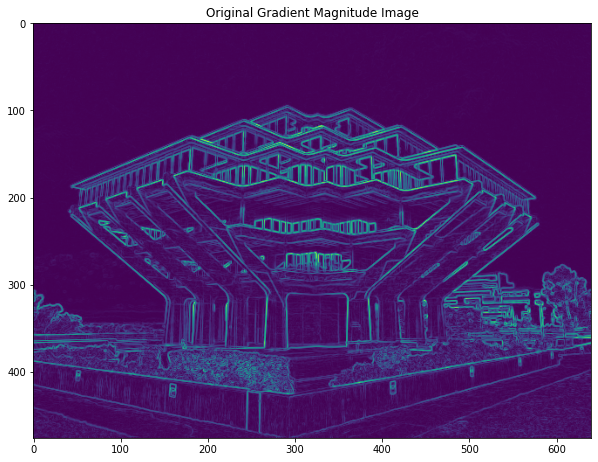

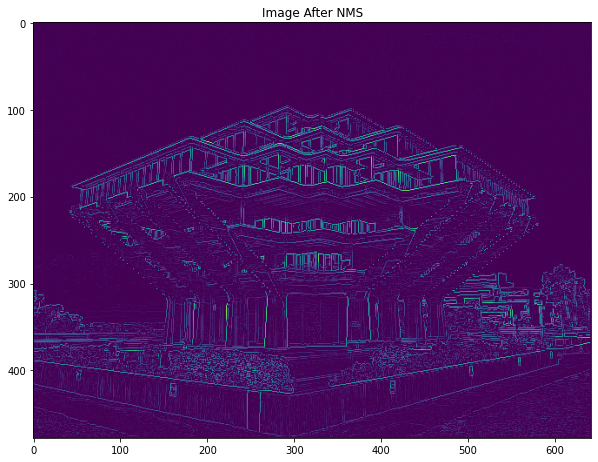

In [142]:
canny_image_geisel = canny_detector(g_sel, 0.9)

Text(0.5, 1.0, 'Final edge image after thresholding')

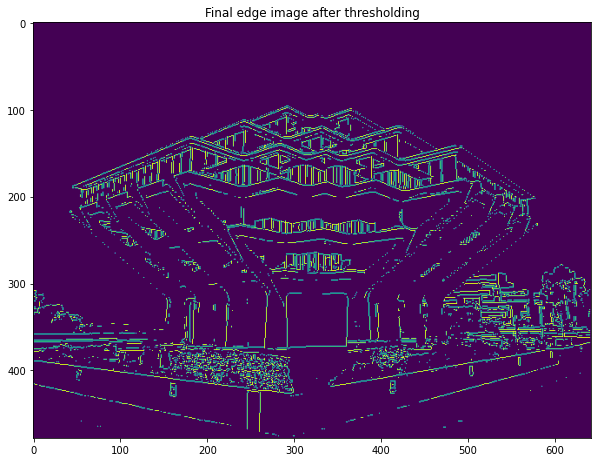

In [143]:
plt.figure(figsize = [10,10])
plt.imshow(canny_image_geisel)
plt.title('Final edge image after thresholding')

The value of t_e used was 0.9.

### Question 2

#### Part (i)

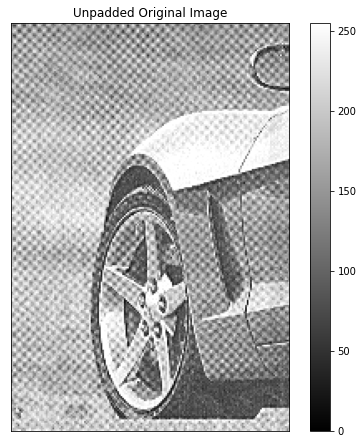

In [144]:
# reading image and displaying unpadded original image
im_car = image.imread('Car.tif')

fig = plt.figure(figsize = [7.5,7.5])
ax = fig.add_subplot()
mpbl = ax.imshow(im_car, cmap = 'gray')
ax.set_title('Unpadded Original Image');
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(mpbl);

In [145]:
# normalizing and padding
im_car = im_car/255
im_car_padded = np.pad(im_car, ((133,), (172,)))

In [146]:
# taking fft
fft_im_car_padded = np.fft.fft2(im_car_padded)

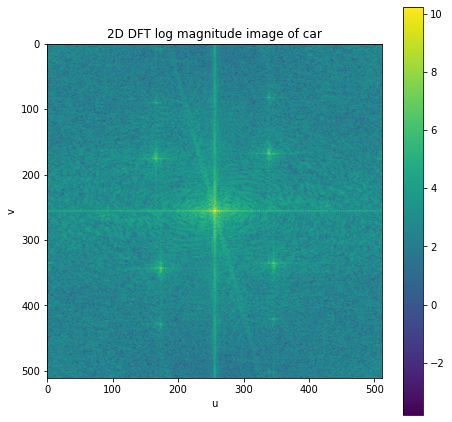

In [147]:
# plotting 2D DFT log_magnitude image
fig = plt.figure(figsize = [7.5,7.5])
ax = fig.add_subplot()
mpbl = ax.imshow((np.log(abs(np.fft.fftshift(fft_im_car_padded)))))
ax.set_xlabel('u')
ax.set_ylabel('v')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_title('2D DFT log magnitude image of car')
fig.colorbar(mpbl);

After zooming into the image using the mpld3 package, I have found the indices of the maximae to the left of the image to be (row_number, column_number):

346, 336  

346, 421

339, 168  

339, 83


We will store this in a list for easy access.

In [148]:
notch_reject_locations = [[346,336], [346,421], [339,168], [339, 83]]

In [149]:
x_axis = np.linspace(-256,255,512)
y_axis = np.linspace(-256,255,512)
[u,v] = np.meshgrid(x_axis,y_axis)

We will write the equation for one notch reject filter.

In [150]:
def dk(u, v, uk, vk):
    return np.sqrt(((u - uk)**2 + (v - vk)**2))

In [151]:
def d_neg_k(u, v, uk, vk):
    return np.sqrt(((u + uk)**2 + (v + vk)**2))

In [152]:
def hnr_term(D_0, n, uk, vk):
    
    hnr = (1/(1+((D_0/dk(u,v,uk,vk))**(2*n))))*(1/(1+((D_0/d_neg_k(u,v,uk,vk))**(2*n))))
    
    return(hnr)

In [153]:
hnr_car = 1

for i in range(len(notch_reject_locations)):
    
    uk = notch_reject_locations[i][0] - 256
    vk = notch_reject_locations[i][1] - 256
    n = 4
    D_0 = 15
    hnr_car = hnr_car * hnr_term(D_0, n, uk, vk)

/home/chaitanya/Documents/odas_test_notebooks/odas/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


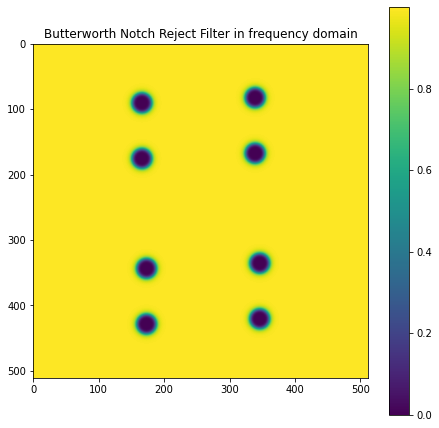

In [154]:
# plotting butterworth Notch Reject Filter in frequency domain
fig = plt.figure(figsize=[7.5,7.5])
ax = fig.add_subplot()
mpbl = ax.imshow(hnr_car)
ax.set_title('Butterworth Notch Reject Filter in frequency domain')
fig.colorbar(mpbl);

In [155]:
# filtering by multiplication with filter in f domain

filtered_fft = hnr_car*np.fft.fftshift(fft_im_car_padded)

# taking ifftshift

fft_inv_shift = np.fft.ifftshift(filtered_fft)

In [156]:
# taking inverse 2D ffit

inv_fft = np.fft.ifft2(fft_inv_shift)

# taking abs of the resulting complex vector

filtered_padded_image = abs(inv_fft)

# cropping image appropriately
filtered_image = filtered_padded_image[133:378, 172:339]

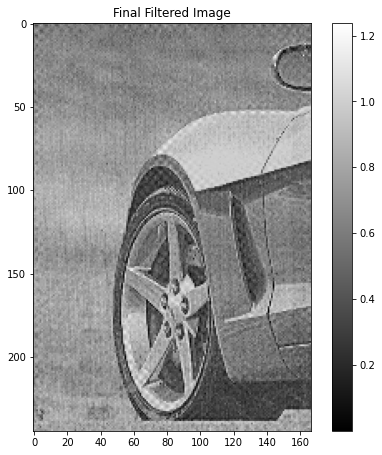

In [157]:
# plotting final filtered image

fig = plt.figure(figsize=[7.5,7.5])
ax = fig.add_subplot()
mpbl = ax.imshow(abs(filtered_image), cmap = 'gray')
ax.set_title('Final Filtered Image')
fig.colorbar(mpbl);

Parameters used were:  
n = 4  
D_0 = 15  
u1 = 346  
v1 = 336  
u2 = 346  
v2 = 421  
u3 = 339  
v3 = 168  
u4 = 339  
v4 = 83

Part (ii)

In [158]:
street = image.imread('Street.png')

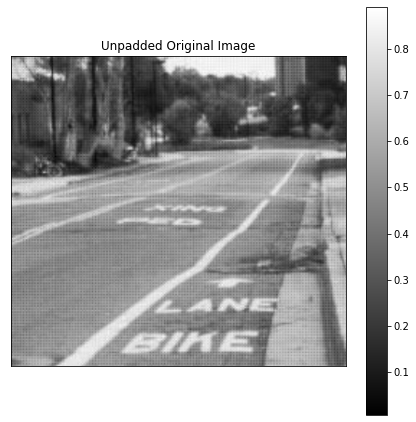

In [159]:
# reading image and displaying unpadded original image
fig = plt.figure(figsize = [7.5,7.5])
ax = fig.add_subplot()
mpbl = ax.imshow(street, cmap = 'gray')
ax.set_title('Unpadded Original Image');
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(mpbl);

In [160]:
street = street[:,1:]

In [161]:
im_street_padded = np.pad(street, (((512-street.shape[0])//2,), ((512-street.shape[1])//2,)))
im_street_padded = im_street_padded/255

In [162]:
fft_im_street_padded = np.fft.fft2(im_street_padded)

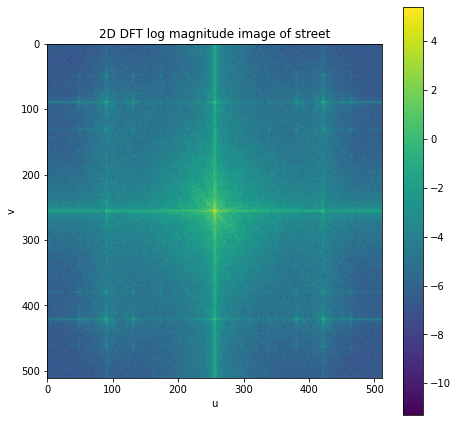

In [163]:
# plotting 2D DFT log_magnitude image
fig = plt.figure(figsize = [7.5,7.5])
ax = fig.add_subplot()
mpbl = ax.imshow((np.log(abs(np.fft.fftshift(fft_im_street_padded)))))
ax.set_xlabel('u')
ax.set_ylabel('v')
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_title('2D DFT log magnitude image of street')
fig.colorbar(mpbl);

We want to remove the burst along u = 0 axis and v = 0 axis

We will zoom into the image to extract the indices of the bursts:

burst along u = 0 axis.

422, 256

burst along v = 0 axis.

256, 422

In [164]:
term_21 = hnr_term(25, 4, 0, 422-256)
term_22 = hnr_term(25, 4, 422-256, 0)
term_2 = term_21*term_22

/home/chaitanya/Documents/odas_test_notebooks/odas/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


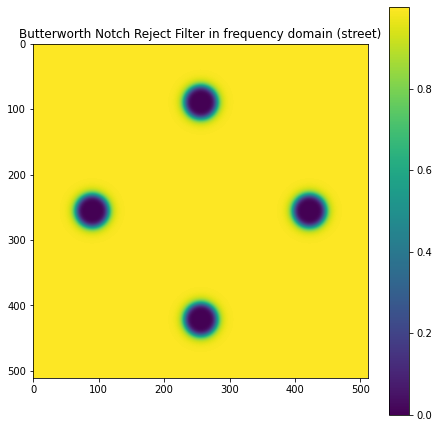

In [165]:
# plotting butterworth Notch Reject Filter in frequency domain
fig = plt.figure(figsize=[7.5,7.5])
ax = fig.add_subplot()
mpbl = ax.imshow(term_2)
ax.set_title('Butterworth Notch Reject Filter in frequency domain (street)')
fig.colorbar(mpbl);

In [166]:
# multiplying fft with this mask

filtered_fft = np.fft.fftshift(fft_im_street_padded) * term_2

# we need to shift this filtered_fft in the inverse direction of the shift

filtered_shifted_fft = np.fft.fftshift(filtered_fft)

# we need to take the inverse fft of this to get the padded filtered image

padded_filtered_image = np.fft.ifft2(filtered_shifted_fft)

# we usually get complex array due to some inaccuracies. We will take only the magnitude of the array.
filtered_image = padded_filtered_image[90:421,77:434]


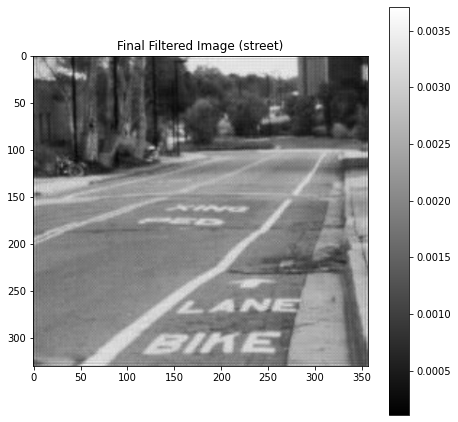

In [167]:
# plotting final filtered image

fig = plt.figure(figsize=[7.5,7.5])
ax = fig.add_subplot()
mpbl = ax.imshow(abs(filtered_image), cmap = 'gray')
ax.set_title('Final Filtered Image (street)')
fig.colorbar(mpbl);

Parameters used were:
n = 4  
D_0 = 25  
u1 = 422  
v1 = 256  
u2 = 256  
v2 = 422  


### Question 3

Acknowledgement: Much of the code below is from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html.

All of the code in the part until after training is 100% from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Specific references have been given when applicable.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# Code from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


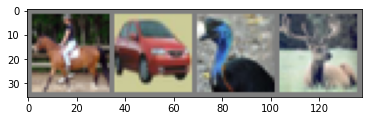

horse   car  bird  deer


In [3]:
# Code from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
# Code from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
# Code from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
# Code from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

/home/chaitanya/Documents/odas_test_notebooks/odas/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


[1,  2000] loss: 2.229
[1,  4000] loss: 1.866
[1,  6000] loss: 1.675
[1,  8000] loss: 1.556
[1, 10000] loss: 1.485
[1, 12000] loss: 1.446
[2,  2000] loss: 1.364
[2,  4000] loss: 1.351
[2,  6000] loss: 1.343
[2,  8000] loss: 1.301
[2, 10000] loss: 1.288
[2, 12000] loss: 1.269
Finished Training


ii. How many images and batches are used to train the network?

There are 50000 images.

Each batch has 4 images, so the total number of batches is 12500, since 12500 * 4 = 50000.

In [12]:
trainset.__len__()

50000

iii.  Do we normalize the images? What do we do in the example?

We do normalize the images. In the example, we defined a transform as consisting of toTensor and normalization. In the normalization, we normalize the images.



iv. Plotting training loss

In [7]:
# plotting training loss

losses = [2.229, 1.866, 1.675, 1.556, 1.485, 1.446, 1.364, 1.351, 1.343, 1.301, 1.288, 1.269]

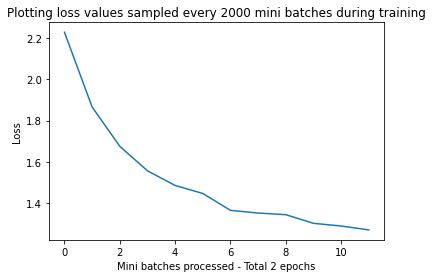

In [10]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(losses)
ax.set_xlabel('Mini batches processed - Total 2 epochs')
ax.set_ylabel('Loss')
ax.set_title('Plotting loss values sampled every 2000 mini batches during training');

v. Now the network is done training. Can you check some successful cases and some failure cases (show some images classified by the network)?

In [52]:
# Code adopted from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# to check the results of the network on the images, we must first retrieve images
# we should do so from the test loader

loader_iterable = iter(testloader)
images, labels = loader_iterable.next() # this should retrieve a minibatch

# we must propogate our images through the network.

outputs = net(images)

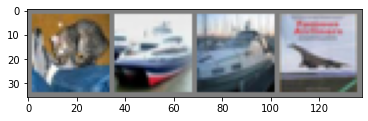

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship  ship


In [53]:
# Code adopted from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Above, we get to see that for the first three images, we got the right output, but this is not the case for the last image.

vi. Can you visualize the output of the 1st layer of CNN using one image from the training set?

In [97]:
# the kernel has been trained. All we need to do is convolve with a few images.

# step 1: obtain images

# we will use our images from previous step

In [98]:
# our weights are stored in net
# https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html, from where I have adopted this code

all_net_params = list(net.parameters())


what if we defined a sub_net using just the first layer params of net?

If we want to do that, we will need to create a new class of network, I think

In [99]:
# Code adopted from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

class Net2(nn.Module):
    def __init__(self, params_layer_1):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv1.weight = params_layer_1 # adopted from https://discuss.pytorch.org/t/how-to-set-nn-conv2d-weights/67407
    def forward(self, x):
        x = self.conv1(x)
        return x

In [100]:
net_2 = Net2(all_net_params[0])
first_layer_output = net_2(images)

In [118]:
def imshow_detach(img):
    """Adopted from the function imshow() at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html"""
    npimg = img.detach().numpy()
    npimg_tp = np.transpose(npimg, (1, 2, 0))
    npimg_tp_avg = np.mean(npimg_tp, axis = 2)
    plt.imshow(npimg_tp_avg)
    plt.title('After first convolution using learned weights: Wow!')
    plt.show()

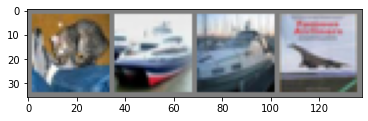

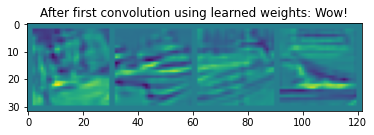

In [119]:
# Code adopted from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
imshow(torchvision.utils.make_grid(images))
imshow_detach(torchvision.utils.make_grid(first_layer_output))

Note: I averaged feature maps across 6 channels of the resultant feature map.

References:

1. https://www.youtube.com/watch?v=sRFM5IEqR2w

2. https://matplotlib.org/3.1.0/gallery/mplot3d/surface3d.html